In [12]:
import numpy as np
import preprocessing as pp
import evaluator as ev

RANDOM_STATE = 42

In [13]:
import data_loader as dl
import importlib
importlib.reload(dl)
m = dl.load_data()
m


✓ Successfully loaded 3919 matches from matchweeks 1-38

Sample data:
                  home_team         away_team  home_score  away_score outcome
0                 Liverpool       Bournemouth           4           2  H_or_D
1               Aston Villa  Newcastle United           0           0  H_or_D
2  Brighton and Hove Albion            Fulham           1           1  H_or_D
3         Nottingham Forest         Brentford           3           1  H_or_D
4                Sunderland   West Ham United           3           0  H_or_D

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   match_id          3919 non-null   object        
 1   season            3919 non-null   int64         
 2   kickoff           3919 non-null   object        
 3   home_team         3919 non-null   object        
 4   home_

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome,winner,kickoff_datetime
0,2561895,2025,2025-08-15 20:00:00,Liverpool,14,4,Bournemouth,91,2,H_or_D,Liverpool,2025-08-15 20:00:00
1,2561896,2025,2025-08-16 12:30:00,Aston Villa,7,0,Newcastle United,4,0,H_or_D,Draw,2025-08-16 12:30:00
2,2561897,2025,2025-08-16 15:00:00,Brighton and Hove Albion,36,1,Fulham,54,1,H_or_D,Draw,2025-08-16 15:00:00
3,2561898,2025,2025-08-17 14:00:00,Nottingham Forest,17,3,Brentford,94,1,H_or_D,Nottingham Forest,2025-08-17 14:00:00
4,2561899,2025,2025-08-16 15:00:00,Sunderland,56,3,West Ham United,21,0,H_or_D,Sunderland,2025-08-16 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3914,803537,2015,2016-05-15 15:00:00,Swansea City,80,1,Manchester City,43,1,H_or_D,Draw,2016-05-15 15:00:00
3915,803538,2015,2016-05-15 15:00:00,Everton,11,3,Norwich City,45,0,H_or_D,Everton,2016-05-15 15:00:00
3916,803539,2015,2016-05-15 15:00:00,Watford,57,2,Sunderland,56,2,H_or_D,Draw,2016-05-15 15:00:00
3917,803540,2015,2016-05-15 15:00:00,Newcastle United,4,5,Tottenham Hotspur,6,1,H_or_D,Newcastle United,2016-05-15 15:00:00


In [14]:
from sklearn.ensemble import RandomForestClassifier
def predict_random_forest(df):

    x_train, y_train, x_test, y_test, test_df, label_map, features = pp.prepare_data(df)

    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight='balanced',
    )

    rf_model.fit(x_train, y_train)
    #Predict with RandomForestClassifier the probability of H_or_D or A
    prob = rf_model.predict_proba(x_test)
    pred_labels = np.argmax(prob, axis=1)


    ev.evaluate(y_test, prob, pred_labels, test_df, label_map, features, rf_model.feature_importances_)

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022] [2023, 2024, 2025]
logloss: 0.38514770983578217
accuracy: 0.8225255972696246
Confusion matrix (rows true, cols pred):
[[532  59]
 [ 97 191]]
Precision: 0.8048934817170111
Recall: 0.7816818245910886


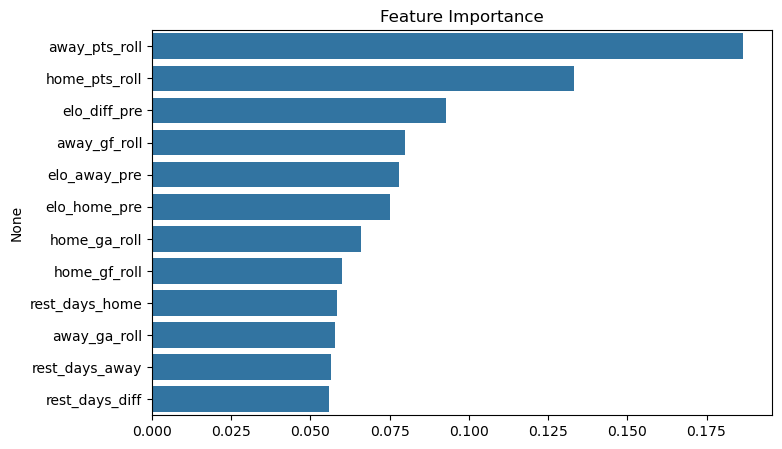

In [15]:
importlib.reload(pp)
importlib.reload(ev)
predict_random_forest(m)

In [16]:
import lightgbm as lgb
def predict_lightgbm(df):
    X_train, y_train, X_test, y_test, test_df, label_map, features = pp.prepare_data(df)

    params = {
        'objective': 'multiclassova',
        'num_class': 2,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'seed': RANDOM_STATE,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }
    lgb_tr = lgb.Dataset(X_train, label=y_train)
    gbm = lgb.train(params, lgb_tr, num_boost_round=1000)
    model = gbm


    preds = model.predict(X_test)
    pred_labels = np.argmax(preds, axis=1)
    ev.evaluate(y_test, preds, pred_labels, test_df, label_map, features, model.feature_importance(importance_type='gain'))

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022] [2023, 2024, 2025]
logloss: 0.5575434816201174
accuracy: 0.8156996587030717
Confusion matrix (rows true, cols pred):
[[519  72]
 [ 90 198]]
Precision: 0.7927750410509031
Recall: 0.7828362944162437


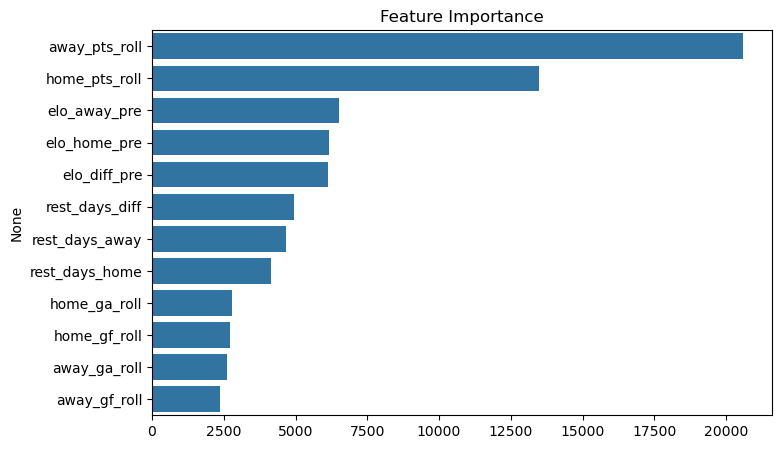

In [17]:
importlib.reload(pp)
importlib.reload(ev)
predict_lightgbm(m)

In [18]:
from xgboost import XGBClassifier

def predict_xgboost(df):
    X_train, y_train, X_test, y_test, test_df, label_map, features = pp.prepare_data(df)

    xgb_model = XGBClassifier(
        n_estimators=500,
        num_class=2,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='multi:softprob',  # for multiclass probability output
        eval_metric='mlogloss'       # multi-class log loss
    )

    # Fit model
    xgb_model.fit(X_train, y_train)

    # Predict probabilities
    prob = xgb_model.predict_proba(X_test)
    pred_labels = np.argmax(prob, axis=1)
    feature_importances = xgb_model.get_booster().get_score(importance_type='gain')

    # Evaluate model
    ev.evaluate(y_test, prob, pred_labels, test_df, label_map, features, feature_importances)

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022] [2023, 2024, 2025]
logloss: 0.4142800045392442
accuracy: 0.8065984072810012
Confusion matrix (rows true, cols pred):
[[516  75]
 [ 95 193]]
Precision: 0.78233321933703
Recall: 0.7716176677946982


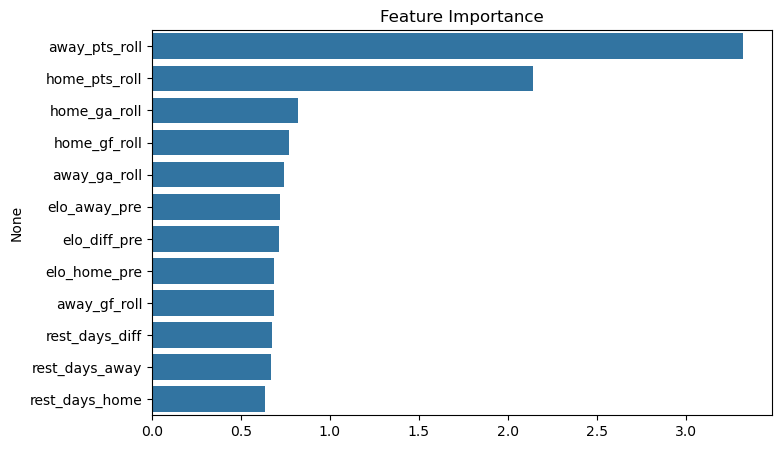

In [19]:
importlib.reload(pp)
importlib.reload(ev)
predict_xgboost(m)